In [12]:
# === Cell 0: Imports, paths, config ===
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# skimage features (modern names!)
from skimage.feature import hog, local_binary_pattern
from skimage.feature import graycomatrix, graycoprops

# ---- Paths ----
BASE = Path(r"c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project")
DATA = BASE / "data"
OUR_DIR = DATA / "our_images"

# Prefer the TEXTURE model; fallback to baseline if not found
MODEL_PATHS = [
    BASE / "models_texture" / "final_model_all.pkl",
    BASE / "models"         / "final_model.pkl",
]

# ---- Inference threshold ----
THRESH = 0.6

# ---- Image/grid config (must match training) ----
IMG_W, IMG_H = 800, 600
CELL_W, CELL_H = IMG_W // 8, IMG_H // 8  # 100x75 per cell

# ---- Feature configs (same as texture notebook) ----
HIST_BINS = 16
HOG_PARAMS = dict(
    orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2),
    block_norm='L2-Hys', feature_vector=True
)

# Texture configs
GLCM_DISTANCES = [1]
GLCM_ANGLES    = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPS     = ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']
LBP_P, LBP_R   = 8, 1
GABOR_THETAS   = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GABOR_SIGMAS   = [1.0, 2.0, 3.0]

print("OUR_DIR exists:", OUR_DIR.exists())
print("Model priority:", [str(p) for p in MODEL_PATHS])


OUR_DIR exists: True
Model priority: ['c:\\Users\\aryan\\OneDrive\\Desktop\\SEM 3\\DS 203\\DS203-Wildlife-Detection-Project\\models_texture\\final_model_all.pkl', 'c:\\Users\\aryan\\OneDrive\\Desktop\\SEM 3\\DS 203\\DS203-Wildlife-Detection-Project\\models\\final_model.pkl']


In [13]:
# === Cell 1: Load model ===
model = None
for mp in MODEL_PATHS:
    if mp.exists():
        with open(mp, "rb") as f:
            model = pickle.load(f)
        print("Loaded model from:", mp)
        break

if model is None:
    raise FileNotFoundError("No model found. Expected models_texture/final_model.pkl or models/final_model.pkl")
print("Model type:", type(model).__name__)


Loaded model from: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\models_texture\final_model_all.pkl
Model type: XGBClassifier


In [14]:
# === Cell 2: Preprocessing (center-crop 4:3, skip small, no save) ===
def _to_bgr(img):
    if img is None: return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img

def center_crop_to_aspect(img, aspect=4/3):
    h, w = img.shape[:2]
    cur = w / h
    if abs(cur - aspect) < 1e-6:
        return img
    if cur > aspect:
        new_w = int(h * aspect)
        x0 = (w - new_w)//2
        return img[:, x0:x0+new_w]
    else:
        new_h = int(w / aspect)
        y0 = (h - new_h)//2
        return img[y0:y0+new_h, :]

def preprocess(img):
    """
    BGR -> center-crop to 4:3 -> if <800x600 after crop: skip (return None)
    else downscale to exactly 800x600 (INTER_AREA).
    """
    bgr = _to_bgr(img)
    if bgr is None:
        return None
    cropped = center_crop_to_aspect(bgr, aspect=4/3)
    h, w = cropped.shape[:2]
    if w < IMG_W or h < IMG_H:
        # No upscaling allowed in your spec; skip this image.
        return None
    return cv2.resize(cropped, (IMG_W, IMG_H), interpolation=cv2.INTER_AREA)


In [15]:
# === Cell 3: Features (RGB+HSV hist, HOG, GLCM, LBP, Gabor) ===
def color_hist_feats(bgr, bins=HIST_BINS):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    feats = []
    for space in (rgb, hsv):
        for ch in range(3):
            h, _ = np.histogram(space[:,:,ch], bins=bins, range=(0,255), density=True)
            feats.append(h.astype(np.float32))
    return np.concatenate(feats)  # 6*bins = 96 dims for bins=16

def hog_feats(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    h = hog(gray, **HOG_PARAMS)
    return h.astype(np.float32)

def glcm_feats(gray):
    # normalize to 0..255 uint8 for GLCM
    gray8 = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    g = graycomatrix(gray8, GLCM_DISTANCES, GLCM_ANGLES, 256, symmetric=True, normed=True)
    feats = [graycoprops(g, p).ravel() for p in GLCM_PROPS]  # len = 6 * len(angles) = 24
    return np.concatenate(feats).astype(np.float32)

def lbp_feats(gray, P=LBP_P, R=LBP_R):
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    n_bins = P + 2
    h, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return h.astype(np.float32)  # ~10 dims

def gabor_feats(gray):
    feats = []
    for th in GABOR_THETAS:
        for sg in GABOR_SIGMAS:
            k = cv2.getGaborKernel((9,9), sg, th, 8.0, 0.5, 0, ktype=cv2.CV_32F)
            f = cv2.filter2D(gray, cv2.CV_32F, k)
            feats += [float(f.mean()), float(f.std(ddof=1))]
    return np.array(feats, dtype=np.float32)  # 4*3*2 = 24 dims

def extract_features_texture(cell_bgr):
    bgr  = _to_bgr(cell_bgr)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    c_h  = color_hist_feats(bgr)        # 96
    h    = hog_feats(bgr)               # ~hundreds
    gcm  = glcm_feats(gray)             # 24
    lbp  = lbp_feats(gray)              # ~10
    gab  = gabor_feats(gray)            # 24
    return np.concatenate([c_h, h, gcm, lbp, gab]).astype(np.float32)


Found 15 images in c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\our_images
➡️  Skipped (too small after crop): images (1).jpg
➡️  Skipped (too small after crop): images (2).jpg
➡️  Skipped (too small after crop): images (3).jpg
➡️  Skipped (too small after crop): images (4).jpg
➡️  Skipped (too small after crop): images.jpg


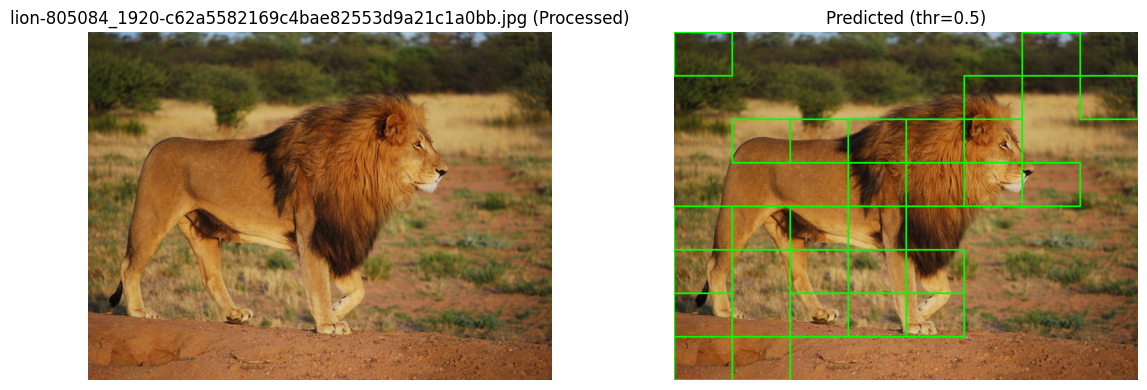

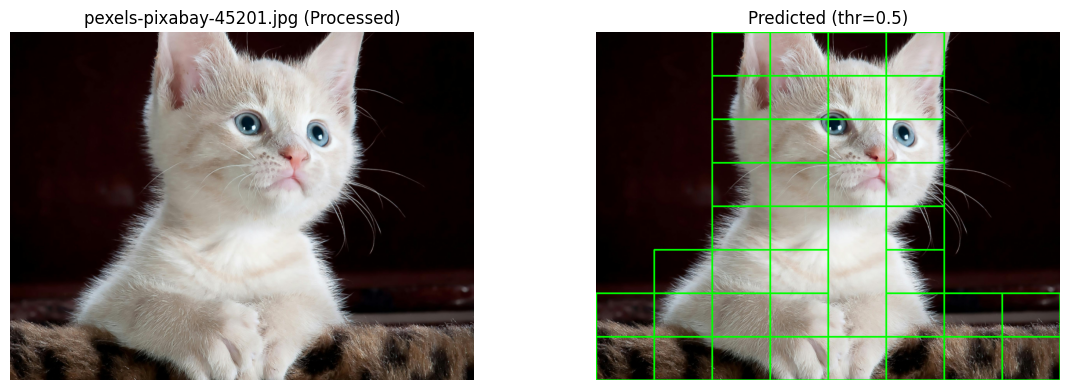

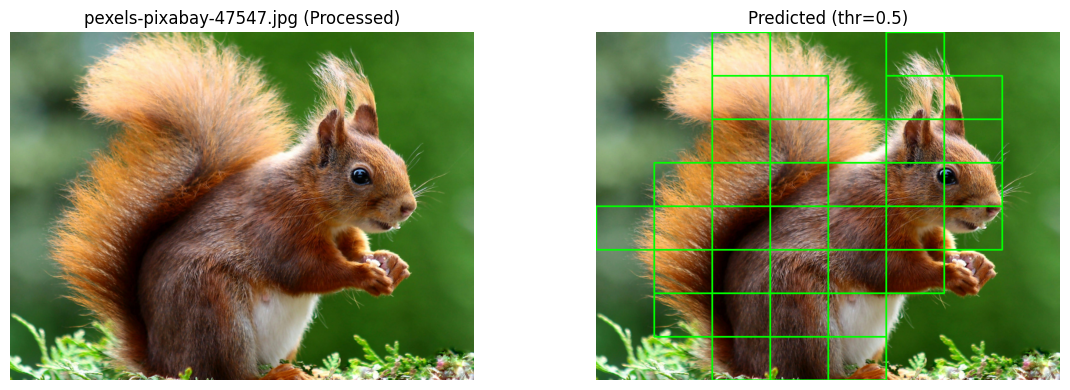

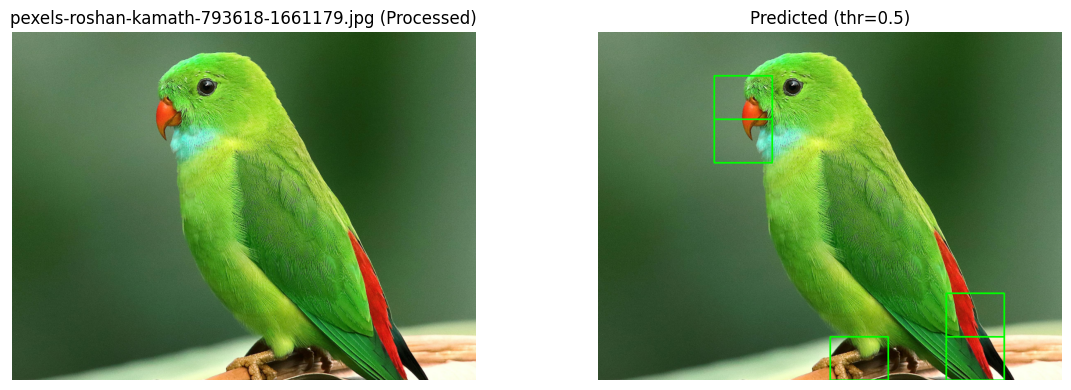

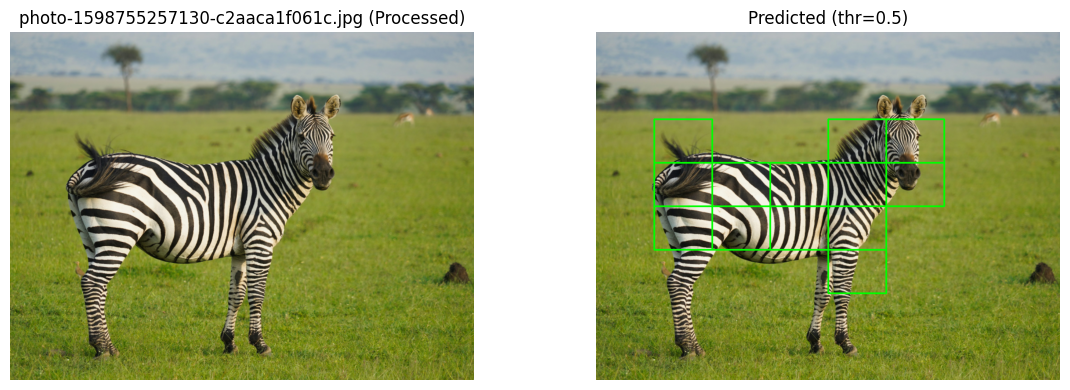

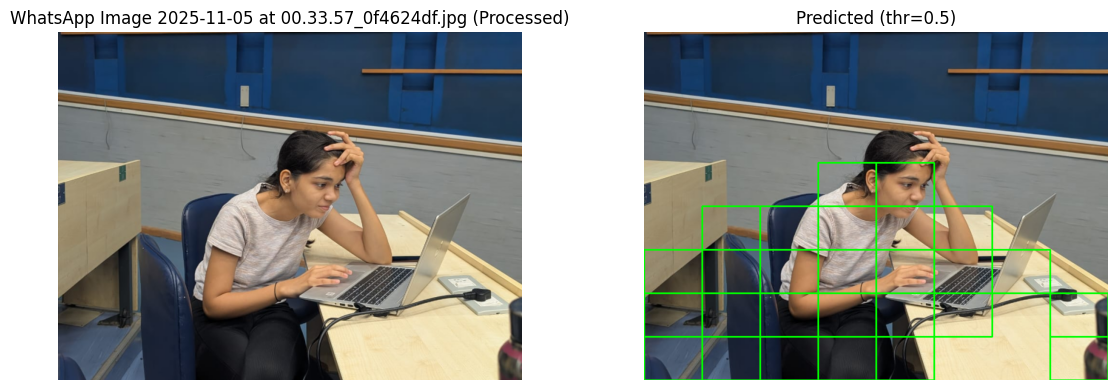

➡️  Skipped (too small after crop): WhatsApp Image 2025-11-05 at 00.35.16_d57207ff.jpg
➡️  Skipped (too small after crop): WhatsApp Image 2025-11-05 at 00.35.31_5b1286c0.jpg
➡️  Skipped (too small after crop): WhatsApp Image 2025-11-05 at 00.35.39_c8105513.jpg


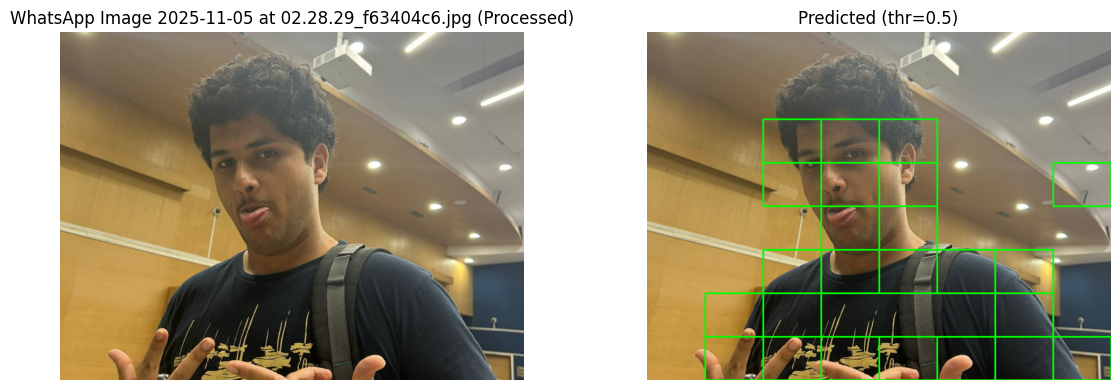

,ImageFileName,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
0,lion-805084_1920-c62a5582169c4bae82553d9a21c1a...,1,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,pexels-pixabay-45201.jpg,0,0,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,pexels-pixabay-47547.jpg,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
3,pexels-roshan-kamath-793618-1661179.jpg,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,photo-1598755257130-c2aaca1f061c.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,WhatsApp Image 2025-11-05 at 00.33.57_0f4624df...,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,0,1
6,WhatsApp Image 2025-11-05 at 02.28.29_f63404c6...,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,1,1


In [17]:
# === Cell 4: Run on ALL images in data/our_images (no saving; display only) ===
def slice_cells(img):
    cells = []
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            cells.append(img[y0:y1, x0:x1])
    return cells

def draw_overlay(img, preds, thickness=2):
    out = img.copy()
    k = 0
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            if preds[k] == 1:
                cv2.rectangle(out, (x0, y0), (x1, y1), (0,255,0), thickness)
            k += 1
    return out

# Collect images
images = sorted([p for p in OUR_DIR.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}])
print(f"Found {len(images)} images in {OUR_DIR}")

THRESH = 0.5

all_rows = []
for img_path in images:
    raw = cv2.imread(str(img_path))
    if raw is None:
        print(f"❌ Unreadable, skipping: {img_path.name}")
        continue

    proc = preprocess(raw)
    if proc is None:
        print(f"➡️  Skipped (too small after crop): {img_path.name}")
        continue

    cells = slice_cells(proc)
    X = np.vstack([extract_features_texture(c) for c in cells])

    # probabilities
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    else:
        dec = model.decision_function(X)
        proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    preds = (proba >= THRESH).astype(int)

    # record row (no saving to disk)
    row = {"ImageFileName": img_path.name}
    for i, v in enumerate(preds, start=1):
        row[f"c{i:02d}"] = int(v)
    all_rows.append(row)

    # show overlay inline
    overlay = draw_overlay(proc, preds)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)); plt.title(img_path.name + " (Processed)"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title(f"Predicted (thr={THRESH})"); plt.axis("off")
    plt.tight_layout(); plt.show()

# Show final predictions table (not saved)
preds_df = pd.DataFrame(all_rows, columns=["ImageFileName"] + [f"c{i:02d}" for i in range(1,65)])
preds_df
